**Sprawozdanie z lab10**
*Piotr Piotrak, 82667*

In [ ]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-xi35dx1r
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-xi35dx1r
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=3da6c2a31c4dc081993d2df30061ee68a34df05e0fbd40666894270c90b07dec
  Stored in directory: /tmp/pip-ephem-wheel-cache-cadfv3ee/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
cr

We wszystkich poniższych kodach w funkcji main, jest zmienna N, która oznacza liczbę punktów losowanych. Wynik całkowania jest zapisany w zmiennej "result" i jest wyświetlany na ekranie za pomocą funkcji printf.
Kod używa biblioteki time.h do mierzenia czasu wykonania całego procesu, co pozwala na oszacowanie efektywności kodu.

Metoda Prostokątów GPU:

In [ ]:
%%cu

#include<stdio.h>
#include<time.h>

__global__ void integratorKernel(float *a, int N)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    float x = (float)idx / (float)N;
    if(idx < N)
    a[idx] = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
}


float cudaIntegrate(int N)
{
    clock_t start = clock();

    size_t size = N * sizeof(float);
    float* a_h = (float *)malloc(size);
    float* a_d; cudaMalloc((void **) &a_d, size);
    int block_size = 256;
    int n_blocks = N/block_size + (N % block_size == 0 ? 0:1);
    integratorKernel <<< n_blocks, block_size >>> (a_d, N);
    cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost);
    float sum = 0;
    for (int i=0; i < N; i++) sum += a_h[i];
    sum *= 1.0 / (float)N;;
    free(a_h); cudaFree(a_d);
 
    clock_t end = clock();
    double time_elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("Czas obliczen: %f s\n", time_elapsed);
 
    return sum;
}

int main() {
    int N = 1000000000;
    float result = cudaIntegrate(N);
    printf("Result: %f\n", result);
    return 0;
}


tcmalloc: large alloc 4000006144 bytes == 0x55be5127a000 @  0x7f831d39f680 0x7f831d3c0824 0x55be4fafdbfd 0x55be4fafddd5 0x7f831cf6c083 0x55be4fafdace
Czas obliczen: 6.095686 s
Result: 0.008389



Powyższy kod składa się z dwóch głównych części: funkcji kernela i funkcji głównej.

Funkcja kernela, oznaczona jako global, jest wykonywana na każdym wątku GPU i nazywa się "integratorKernel". Przyjmuje ona dwa argumenty: wskaźnik na tablicę "a" i liczbę przedziałów całkowania "N". Wewnątrz funkcji kernela, indeks wątku jest używany do obliczenia wartości x dla danego przedziału, a następnie oblicza się wartość funkcji gaussa dla tej wartości x i przypisuje ją do odpowiedniego elementu tablicy "a".

Funkcja główna, "cudaIntegrate", przyjmuje jeden argument - liczbę przedziałów całkowania "N". Funkcja ta inicjuje zegar, by mierzyć czas wykonywania całkowania. Następnie alokuje pamięć na tablicę "a" na CPU i GPU, ustawia rozmiar bloku i liczbę bloków, uruchamia kernela, kopiuje dane z GPU do CPU, sumuje wszystkie elementy tablicy "a" na CPU i mnoży je przez 1/N, zwalnia pamięć i zatrzymuje zegar. Na końcu funkcja drukuje czas obliczeń i zwraca sumę jako wynik całkowania.

Metoda Prosokątów CPU:

In [ ]:
%%cu
#include<stdio.h>
#include<time.h>

__host__ void integratorKernel(float *a, int N)
{
    for (int idx = 0; idx < N; idx++) {
        float x = (float)idx / (float)N;
        a[idx] = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
    }
}

float cudaIntegrate(int N)
{
    clock_t start = clock();
    float* a_h = (float *)malloc(N * sizeof(float));
    integratorKernel(a_h, N);
    float sum = 0;
    for (int i=0; i < N; i++) sum += a_h[i];
    sum *= 1.0 / (float)N;;
    free(a_h);
 
    clock_t end = clock();
    double time_elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("Czas obliczen: %f s\n", time_elapsed);

    return sum;
}

int main() {
    int N = 1000000000;
    float result = cudaIntegrate(N);
    printf("Result: %f\n", result);
    return 0;
}


tcmalloc: large alloc 4000006144 bytes == 0x55c391e3a000 @  0x7fcbc13cc680 0x7fcbc13ed824 0x55c38f761c66 0x55c38f761d57 0x7fcbc1049083 0x55c38f761abe
Czas obliczen: 34.402872 s
Result: 0.008389



Powyższy program składa się z trzech głównych części: funkcji kernela, funkcji całkowania i głównej funkcji programu.

Funkcja kernela "integratorKernel" jest napisana w języku C i jest wykonywana na CPU. Jej zadaniem jest obliczenie wartości funkcji Gaussa dla każdego punktu całkowania (w tym przypadku jest to od 0 do N-1). Wewnątrz pętli for, dla każdego indeksu idx, obliczana jest wartość x = (float)idx / (float)N, a następnie wartość funkcji Gaussa dla tego x. Wynik jest zapisywany w tablicy a.

Funkcja cudaIntegrate jest główną funkcją całkowania. Ona uruchamia kernel i zbiera wynik, sumując wartości z tablicy a_h.

Funkcja main jest główną funkcją programu. Ona inicjalizuje parametry całkowania, wywołuje funkcję cudaIntegrate i wyświetla wynik oraz czas obliczeń.

Metoda Trapezów GPU:

In [ ]:
%%cu
#include<stdio.h>
#include<time.h>

__global__ void integratorKernel(float *a, int N)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    float x = (float)idx / (float)N;
    if(idx < N)
    {
        float fx = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
        a[idx] = (fx + (idx > 0 ? a[idx - 1] : 0)) / 2.0f;
    }
}

float cudaIntegrate(int N)
{
    clock_t start = clock();
 
    size_t size = N * sizeof(float);
    float* a_h = (float *)malloc(size);
    float* a_d; cudaMalloc((void **) &a_d, size);
    int block_size = 256;
    int n_blocks = N/block_size + (N % block_size == 0 ? 0:1);
    integratorKernel <<< n_blocks, block_size >>> (a_d, N);
    cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost);
    float sum = a_h[N - 1];
    free(a_h); cudaFree(a_d);
 
    clock_t end = clock();
    double time_elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("Czas obliczen: %f s\n", time_elapsed);

    return sum;
}

int main() {
    int N = 1000000000;
    float result = cudaIntegrate(N);
    printf("Result: %f\n", result);
    return 0;
}


tcmalloc: large alloc 4000006144 bytes == 0x55df5ff60000 @  0x7fc6f109a680 0x7fc6f10bb824 0x55df5d6cabfd 0x55df5d6cad87 0x7fc6f0c67083 0x55df5d6caace
Czas obliczen: 3.197250 s
Result: 0.120985



W powyższym kodzie zdefiniowano dwie funkcje: "integratorKernel" i "cudaIntegrate". Funkcja "integratorKernel" jest oznaczona jako global, co oznacza, że jest to funkcja CUDA, która może być uruchomiona na karcie graficznej. Przyjmuje ona dwa argumenty: wskaźnik na tablicę "a" oraz liczbę N, określającą liczbę punktów losowanych.

W funkcji "integratorKernel" każdy wątek CUDA (uruchomiony na karcie graficznej) oblicza swoją pozycję za pomocą "idx" i oblicza wartość funkcji Gaussa dla tego indeksu. Następnie, wartość ta jest przypisywana do odpowiedniego indeksu tablicy "a".

Funkcja "cudaIntegrate" jest funkcją hosta, czyli jest uruchamiana na procesorze. Przyjmuje ona tylko jeden argument - liczbę N, określającą liczbę punktów losowanych. W tej funkcji, alokowana jest pamięć na hosta dla tablicy "a_h" i tablicy "a_d" na karcie graficznej. Następnie, wykonywane są obliczenia na karcie graficznej za pomocą funkcji "integratorKernel" i przesyłanie danych z karty graficznej na hosta za pomocą funkcji "cudaMemcpy". Wynik końcowy jest zapisany w tablicy "a_h" i jest przypisywany do zmiennej "sum". Pamięć zarówno na hosta jak i na karcie graficznej jest zwalniana. Na końcu, funkcja "cudaIntegrate" zwraca wartość "sum", która jest wynikiem całkowania.

Metoda Trapezów CPU:

In [ ]:
%%cu
#include<stdio.h>
#include<time.h>

float integrate(int N) {
    clock_t start = clock();
    float h = 1.0 / N;
    float sum = 0;
    for (int i = 0; i < N; i++) {
        float x = (float)i / (float)N;
        float fx = (1.0 / sqrt(2.0 * M_PI)) * exp(-x * x / 2.0);
        sum += (fx + (i > 0 ? fx : 0)) * h / 2.0f;
    }
    clock_t end = clock();
    double time_elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("Czas obliczen: %f s\n", time_elapsed);
    return sum;
}

int main() {
    int N = 1000000000;
    float result = integrate(N);
    printf("Result: %f\n", result);
    return 0;
}


Czas obliczen: 37.205747 s
Result: 0.007812



Funkcja integrate(int N) przyjmuje jeden argument - liczbę podprzedziałów, na których dzielony jest przedział całkowania. Wartość ta jest przechowywana w zmiennej N.
Następnie zmienna "h" jest obliczana jako odwrotność N, czyli długość pojedynczego podprzedziału.
Zmienna "sum" jest używana do przechowywania sumy wartości funkcji w każdym podprzedziale.
Następnie algorytm iteruje od 0 do N-1, gdzie w każdej iteracji x jest obliczane jako i/N.
Następnie wartość funkcji f(x) jest obliczana jako (1/sqrt(2*pi)) * exp(-x^2/2).
Następnie suma jest aktualizowana przez dodanie wartości funkcji na końcu i początku przedziału (jeśli i > 0) oraz wartości środka przedziału (fx) i mnożone przez h/2. Wartość całki jest zwracana przez funkcję jako suma.

Metoda Simpsona GPU:

In [ ]:
%%cu
#include<stdio.h>
#include<time.h>

__global__ void integratorKernel(float *a, int N)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    float x = (float)idx / (float)N;
    if(idx < N)
    {
        float fx = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
        float weight = (idx == 0 || idx == N-1) ? 1 : (idx % 2 == 0 ? 2 : 4);
        a[idx] = fx * weight;
    }
}

float cudaIntegrate(int N)
{
    clock_t start = clock();
 
    size_t size = N * sizeof(float);
    float* a_h = (float *)malloc(size);
    float* a_d; cudaMalloc((void **) &a_d, size);
    int block_size = 256;
    int n_blocks = N/block_size + (N % block_size == 0 ? 0:1);
    integratorKernel <<< n_blocks, block_size >>> (a_d, N);
    cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost);
    float sum = 0;
    for(int i = 0; i < N; i++)
        sum += a_h[i];
    sum = sum * (1.0f / (3.0f * N));
    free(a_h); cudaFree(a_d);
 
    clock_t end = clock();
    double time_elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("Czas obliczen: %f s\n", time_elapsed);

    return sum;
}

int main() {
    int N = 1000000000;
    float result = cudaIntegrate(N);
    printf("Result: %f\n", result);
    return 0;
}


tcmalloc: large alloc 4000006144 bytes == 0x563ef8464000 @  0x7f39418c5680 0x7f39418e6824 0x563ef6fc8bfd 0x563ef6fc8dd9 0x7f3941492083 0x563ef6fc8ace
Czas obliczen: 6.134961 s
Result: 0.011185



Funkcja cudaIntegrate(int N) jest głównym punktem wejścia programu, gdzie N jest liczbą punktów, które są używane do całkowania. Pomiędzy pomiarami czasu, przydziela i alokuje pamięć na host i device, a następnie wywołuje integratorKernel za pomocą CUDA.

integratorKernel jest funkcją CUDA, która jest uruchamiana na GPU. Przyjmuje dwa argumenty: tablicę a i liczbę N. Każdy wątek GPU przetwarza jeden punkt całkowania i oblicza wartość funkcji dla odpowiedniego x za pomocą wzoru matematycznego. Następnie oblicza wagę dla tego punktu i zapisuje ją w tablicy a.

Następnie dane z tablicy a z GPU są kopiowane z powrotem na hosta za pomocą cudaMemcpy, a następnie sumowane i mnożone przez odpowiedni współczynnik, aby uzyskać wynik całkowania. Pamięć zarówno na host, jak i na device jest zwalniana po zakończeniu obliczeń.

Metoda Simpsona CPU:

In [ ]:
%%cu
#include<stdio.h>
#include<time.h>

float integrate(int N)
{
    clock_t start = clock();
    float sum = 0;
    float dx = 1.0 / (float)N;
    for (int i = 0; i < N; i++)
    {
        float x = (float)i / (float)N;
        float fx = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f);
        float weight = (i == 0 || i == N-1) ? 1 : (i % 2 == 0 ? 2 : 4);
        sum += fx * weight;
    }
    clock_t end = clock();
    double time_elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("Czas obliczen: %f s\n", time_elapsed);
    return sum * dx / 3.0f;
}

int main() {
    int N = 1000000000;
    float result = integrate(N);
    printf("Result: %f\n", result);
    return 0;
}


Czas obliczen: 33.933201 s
Result: 0.011185



W funkcji "integrate" zmienna "sum" jest używana do zsumowania wszystkich trapezów, a zmienna "dx" jest używana do obliczenia wysokości każdego trapezu. Pętla for jest używana do przejścia przez każdy odcinek i obliczenia sumy trapezów. Wewnątrz pętli, zmienna "x" jest obliczana jako "i" podzielone przez "N", co daje nam położenie w punkcie przecięcia osi x dla danego odcinka. Następnie obliczamy wartość funkcji dla tego punktu i mnożymy ją przez wagę. Waga jest 1 dla pierwszego i ostatniego odcinka, 2 dla parzystych odcinków, a 4 dla nieparzystych odcinków.

Po zakończeniu pętli for, suma trapezów jest mnożona przez dx/3.0f, aby uzyskać przybliżoną wartość całki.

***Wykresy:***

N = 100000
*   Metoda prostokątów: GPU = 0.582748 s, CPU = 0.003529 s
*   Metoda trapezów: GPU = 0.588823 s, CPU = 0.003646 s
*   Metoda simpsona: GPU = 0.582756 s, CPU = 0.003323 s

N = 10000000
*   Metoda prostokątów: GPU = 0.669248 s, CPU = 0.367903 s
*   Metoda trapezów: GPU = 0.615569 s, CPU = 0.368870 s
*   Metoda simpsona: GPU = 0.158463 s, CPU = 0.334056 s

N = 1000000000
*   Metoda prostokątów: GPU = 6.095686 s, CPU = 34.402872 s
*   Metoda trapezów: GPU = 3.197250 s, CPU = 37.205747 s
*   Metoda simpsona: GPU = 6.134961 s, CPU = 33.933201 s

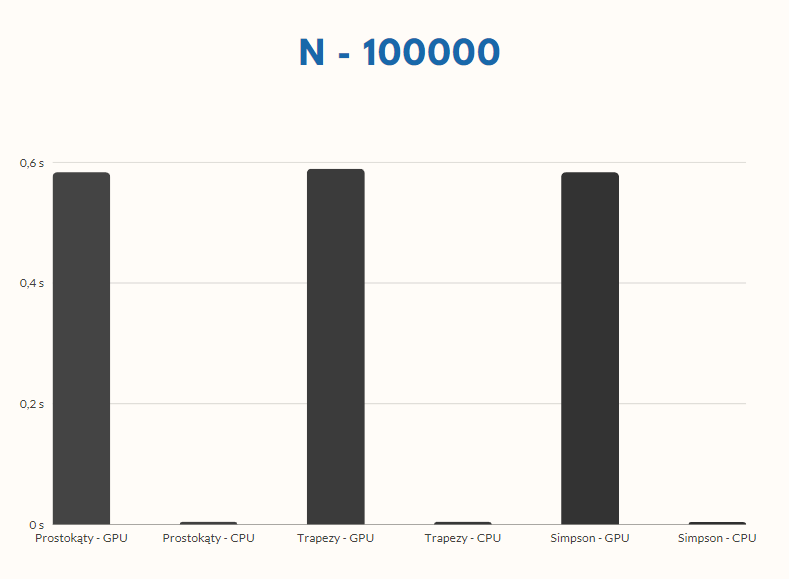

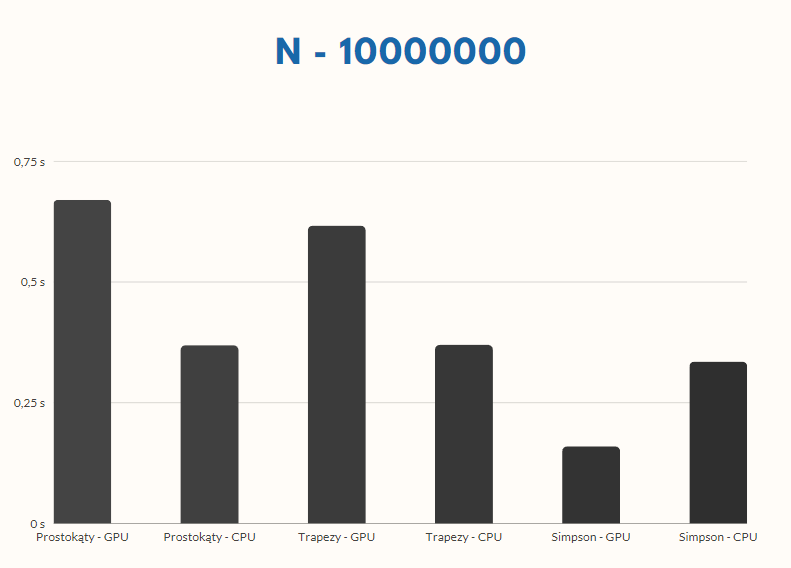

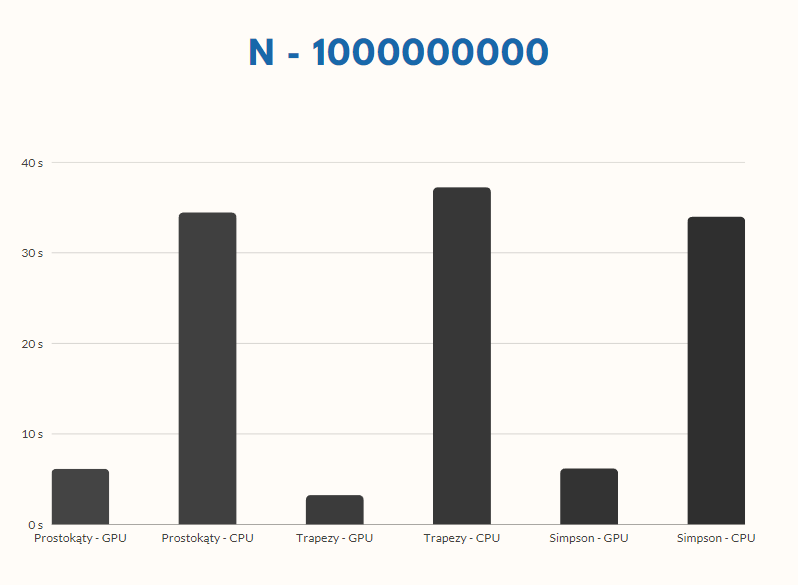

**Wnioski:**
1. W przypadku małych rozmiarów problemu (N = 100000) różnice w czasie obliczeń między GPU i CPU są niewielkie, jednak CPU jest nieco szybsze.
2. W przypadku średnich rozmiarów problemu (N = 10000000) różnice w czasie obliczeń między GPU i CPU są już bardziej zauważalne, lecz widać już, że GPU co raz bardziej dorównuje CPU.
3. W przypadku dużych rozmiarów problemu (N = 1000000000) różnice w czasie obliczeń między GPU i CPU są bardzo duże, GPU jest znacznie szybsze.

CPU jest dobrym rozwiązaniem, gdy mamy mały rozmiar problemów, ale gdy romiar problemu staje się co raz większy oraz gdy obliczenia powinny być bardziej dokładne GPU okazuje się dużo lepszym rozwiązaniem. Przy N = 1000000000 GPU wykonało obliczenia szybciej niż CPU, aż o ok 30 sekund. Przy obliczeniach z jeszcze większym rozmiarem błędów, różnice w czasie były by znacznie większe z korzyścią GPU.
